# Visualize

## Setup

In [ ]:
import sys

# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.4.12
    !pip3 install seaborn==0.13.0
    !git clone https://github.com/PriceWang/MAECG.git
    sys.path.append('./MAECG')

In [1]:
import torch
import torchvision
from utils.data_utils import *
from vit_mae import *
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import torch.nn.functional as F
from engine_finetune_de import loss_fn
from utils.pos_embed import interpolate_pos_embed
from timm.models.vision_transformer import Block
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sn
import pandas as pd

## Example

### Configuration

In [2]:
dataset = torch.load("../storage/ssd/public/guoxin/maecg/challenge-2021/ul_beat.pth")
index = random.randint(0, len(dataset) - 1)
models = [
    mae_vit_base_patch2(signal_length=480).to("cuda"),
    mae_vit_base_patch8(signal_length=480).to("cuda"),
    mae_vit_base_patch32(signal_length=480).to("cuda"),
]
mask_ratios = [0.3, 0.5, 0.7]
patch_sizes = [2, 8, 32]

### Patch Size Example

In [3]:
def plot_one_patchsize(axe, plot_masked, masked_input, mask, patch_size):
    axe.plot(plot_masked, "k", label="Masked")
    axe.fill_between(
        x=range(len(masked_input)),
        y1=-1.1,
        y2=1.1,
        color="none",
        hatch="//",
        edgecolor="black",
        linewidth=0.0,
        where=masked_input == 0,
        alpha=0.3,
    )
    lines = [
        i * patch_size for i, x in enumerate(1 - mask.cpu().squeeze()) if x == 0
    ] + [(i + 1) * patch_size for i, x in enumerate(1 - mask.cpu().squeeze()) if x == 0]
    axe.vlines(x=list(set(lines)), ymin=-1.1, ymax=1.1, color="black", alpha=0.1)
    axe.set_xlim([-30, 510])
    axe.set_ylim([-1.1, 1.1])
    axe.set_xticks([])
    axe.set_yticks([])

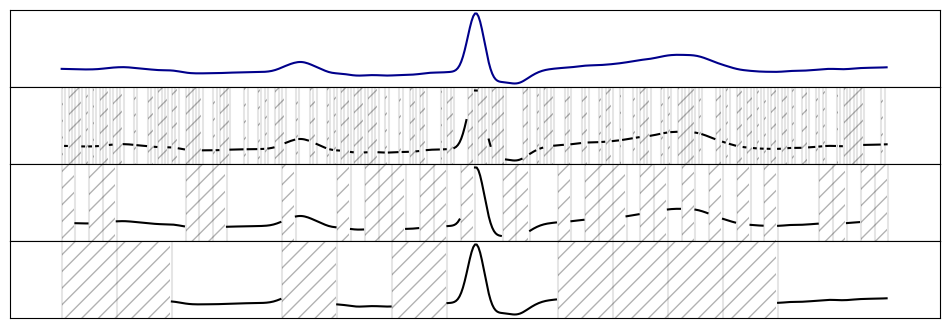

In [5]:
masks = [
    model.forward_encoder(dataset[index].unsqueeze(0).unsqueeze(0).cuda(), mask_ratios[1])[1]
    for model in models
]
masked_inputs = [
    dataset[index].squeeze()
    * (1 - mask.cpu().squeeze().repeat_interleave(patch_sizes[i])).numpy()
    for i, mask in enumerate(masks)
]
plot_maskeds = [
    np.ma.masked_where(masked_input == 0, masked_input)
    for masked_input in masked_inputs
]

fig = plt.figure(figsize=(12, 4))
axes = fig.subplots(nrows=4, ncols=1)
axes[0].plot(dataset[index], "darkblue", label="Original")
axes[0].set_xlim([-30, 510])
axes[0].set_ylim([-1.1, 1.1])
axes[0].set_xticks([])
axes[0].set_yticks([])
for i in range(3):
    plot_one_patchsize(
        axes[i + 1], plot_maskeds[i], masked_inputs[i], masks[i], patch_sizes[i]
    )

fig.subplots_adjust(hspace=0)
fig.savefig(
    "./test_output/patchsize.pdf",
    dpi=1200,
    bbox_inches="tight",
)
plt.show()

### Mask Ratio Example

In [6]:
def plot_one_maskratio(axe, plot_masked, masked_input, mask):
    axe.plot(plot_masked, "k", label="Masked")
    axe.fill_between(
        x=range(len(masked_input)),
        y1=-1.1,
        y2=1.1,
        color="none",
        hatch="//",
        edgecolor="black",
        linewidth=0.0,
        where=masked_input == 0,
        alpha=0.3,
    )
    lines = [
        i * patch_sizes[2] for i, x in enumerate(1 - mask.cpu().squeeze()) if x == 0
    ] + [
        (i + 1) * patch_sizes[2]
        for i, x in enumerate(1 - mask.cpu().squeeze())
        if x == 0
    ]
    axe.vlines(x=list(set(lines)), ymin=-1.1, ymax=1.1, color="black", alpha=0.1)
    axe.set_xlim([-30, 510])
    axe.set_ylim([-1.1, 1.1])
    axe.set_xticks([])
    axe.set_yticks([])

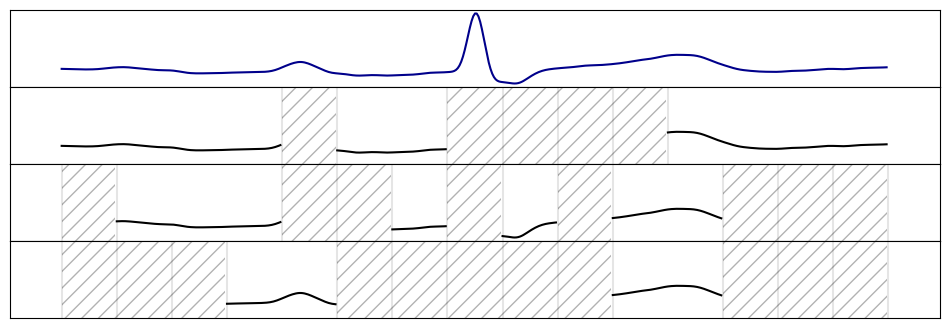

In [7]:
masks = [
    models[2].forward_encoder(dataset[index].unsqueeze(0).unsqueeze(0).cuda(), mask_ratio)[1]
    for mask_ratio in mask_ratios
]
masked_inputs = [
    dataset[index].squeeze()
    * (1 - mask.cpu().squeeze().repeat_interleave(patch_sizes[2])).numpy()
    for mask in masks
]
plot_maskeds = [
    np.ma.masked_where(masked_input == 0, masked_input)
    for masked_input in masked_inputs
]

fig = plt.figure(figsize=(12, 4))
axes = fig.subplots(nrows=4, ncols=1)
axes[0].plot(dataset[index], "darkblue", label="Original")
axes[0].set_xlim([-30, 510])
axes[0].set_ylim([-1.1, 1.1])
axes[0].set_xticks([])
axes[0].set_yticks([])
for i in range(3):
    plot_one_maskratio(axes[i + 1], plot_maskeds[i], masked_inputs[i], masks[i])

fig.subplots_adjust(hspace=0)
fig.savefig(
    "./test_output/maskratio.pdf",
    dpi=1200,
    bbox_inches="tight",
)
plt.show()

## Reconstruction

In [8]:
def recon(model, data, mask_ratio, patch_size):
    latent, mask, ids_restore = model.forward_encoder(
        data.unsqueeze(0).unsqueeze(0).cuda(), mask_ratio
    )
    pred = model.forward_decoder(latent, ids_restore)
    masked_input = data.squeeze() * (
        1 - mask.cpu().squeeze().repeat_interleave(patch_size)
    )
    masked_input = masked_input.numpy()
    temp_mask = masked_input == 0
    plot_recon = np.copy(masked_input)
    plot_masked = np.ma.masked_where(masked_input == 0, masked_input)
    pred_unpatchified = model.unpatchify(pred).squeeze()
    plot_recon[temp_mask] = pred_unpatchified.detach().cpu().numpy()[temp_mask]
    lines = [
        i * patch_size for i, x in enumerate(1 - mask.cpu().squeeze()) if x == 0
    ] + [(i + 1) * patch_size for i, x in enumerate(1 - mask.cpu().squeeze()) if x == 0]
    return masked_input, data, plot_masked, plot_recon, lines

### Reconstruction Example

In [9]:
def plot_one_recon(axes, col, masked_input, plot_ori, plot_masked, plot_recon, lines):
    axes[0][col].plot(plot_ori, "darkblue", label="Original")
    axes[0][col].fill_between(
        x=range(len(masked_input)),
        y1=-1.1,
        y2=1.1,
        color="none",
        hatch="//",
        edgecolor="black",
        linewidth=0.0,
        where=masked_input == 0,
        alpha=0.3,
    )
    axes[0][col].vlines(
        x=list(set(lines)), ymin=-1.1, ymax=1.1, color="black", alpha=0.1
    )
    axes[0][col].set_xlim([-30, 510])
    axes[0][col].set_ylim([-1.1, 1.1])
    axes[0][col].set_xticks([])
    axes[0][col].set_yticks([])

    axes[1][col].plot(plot_masked, "k", label="Masked")
    axes[1][col].fill_between(
        x=range(len(masked_input)),
        y1=-1.1,
        y2=1.1,
        color="none",
        hatch="//",
        edgecolor="black",
        linewidth=0.0,
        where=masked_input == 0,
        alpha=0.3,
    )
    axes[1][col].vlines(
        x=list(set(lines)), ymin=-1.1, ymax=1.1, color="black", alpha=0.1
    )
    axes[1][col].set_xlim([-30, 510])
    axes[1][col].set_ylim([-1.1, 1.1])
    axes[1][col].set_xticks([])
    axes[1][col].set_yticks([])

    axes[2][col].plot(plot_recon, "darkred", label="Reconstructed")
    axes[2][col].fill_between(
        x=range(len(masked_input)),
        y1=-1.1,
        y2=1.1,
        color="none",
        hatch="//",
        edgecolor="black",
        linewidth=0.0,
        where=masked_input == 0,
        alpha=0.3,
    )
    axes[2][col].vlines(
        x=list(set(lines)), ymin=-1.1, ymax=1.1, color="black", alpha=0.1
    )
    axes[2][col].set_xlim([-30, 510])
    axes[2][col].set_ylim([-1.1, 1.1])
    axes[2][col].set_xticks([])
    axes[2][col].set_yticks([])

    axes[3][col].plot(plot_ori, "darkblue", label="Original")
    axes[3][col].plot(plot_recon, "darkred", label="Reconstructed")
    axes[3][col].fill_between(
        x=range(len(masked_input)),
        y1=-1.1,
        y2=1.1,
        color="none",
        hatch="//",
        edgecolor="black",
        linewidth=0.0,
        where=masked_input == 0,
        alpha=0.3,
    )
    axes[3][col].vlines(
        x=list(set(lines)), ymin=-1.1, ymax=1.1, color="black", alpha=0.1
    )
    axes[3][col].set_xlim([-30, 510])
    axes[3][col].set_ylim([-1.1, 1.1])
    axes[3][col].set_xticks([])
    axes[3][col].set_yticks([])

#### Configuration

In [11]:
model = mae_vit_base_patch32(signal_length=480).to("cuda")
checkpoint = torch.load(
    "./pretrains/vit_base_p32/checkpoint-49.pth"
)
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

#### Same dataset

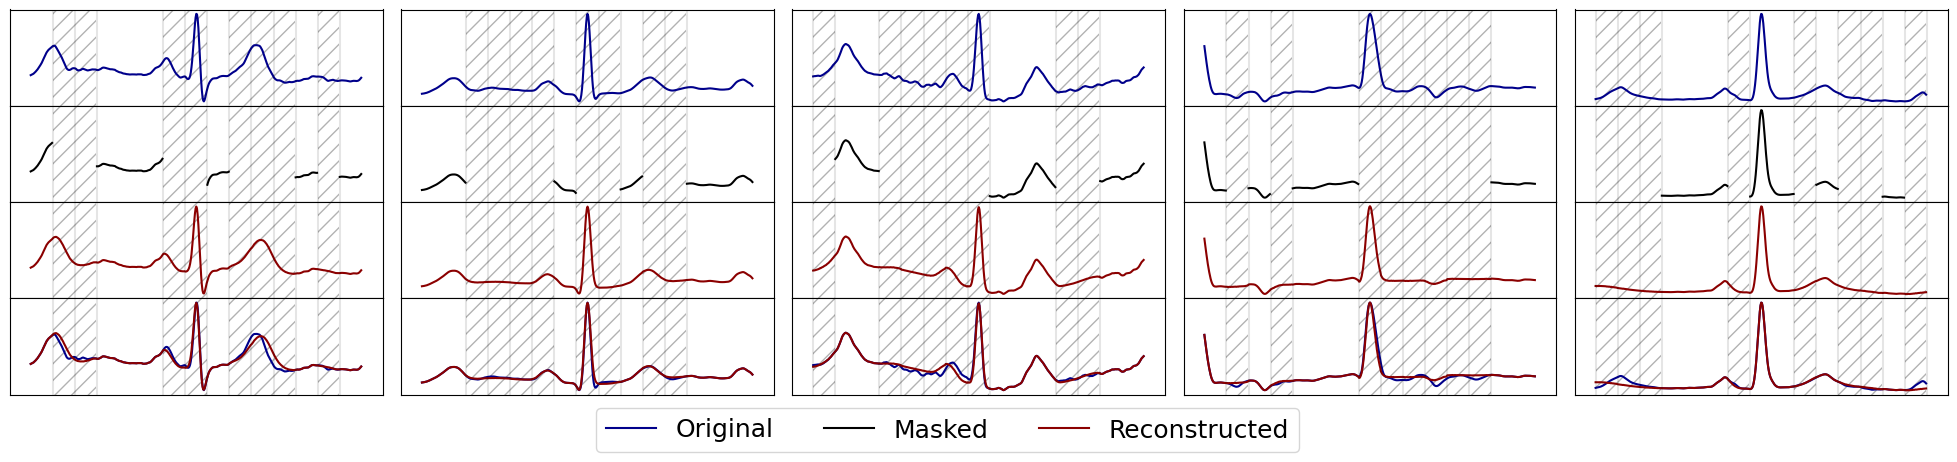

In [12]:
dataset = torch.load("../storage/ssd/public/guoxin/maecg/challenge-2021/ul_beat.pth")
index = [random.randint(0, len(dataset) - 1) for _ in range(5)]

fig = plt.figure(figsize=(25, 5))
axes = fig.subplots(nrows=4, ncols=5)
for i in range(5):
    masked_input, plot_ori, plot_masked, plot_recon, lines = recon(
        model, dataset[index[i]], 0.5, 32
    )
    plot_one_recon(axes, i, masked_input, plot_ori, plot_masked, plot_recon, lines)
lines = []
labels = []
axLine, axLabel = axes[0][0].get_legend_handles_labels()
lines.extend(axLine)
labels.extend(axLabel)
axLine, axLabel = axes[1][0].get_legend_handles_labels()
lines.extend(axLine)
labels.extend(axLabel)
axLine, axLabel = axes[2][0].get_legend_handles_labels()
lines.extend(axLine)
labels.extend(axLabel)

lgd = fig.legend(
    lines,
    labels,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.03),
    ncol=3,
    prop={"size": 18},
)
fig.subplots_adjust(hspace=0, wspace=0.05)
fig.savefig(
    "./test_output/rec_exp.pdf",
    dpi=1200,
    bbox_extra_artists=(lgd,),
    bbox_inches="tight",
)
plt.show()

#### Different Datasets

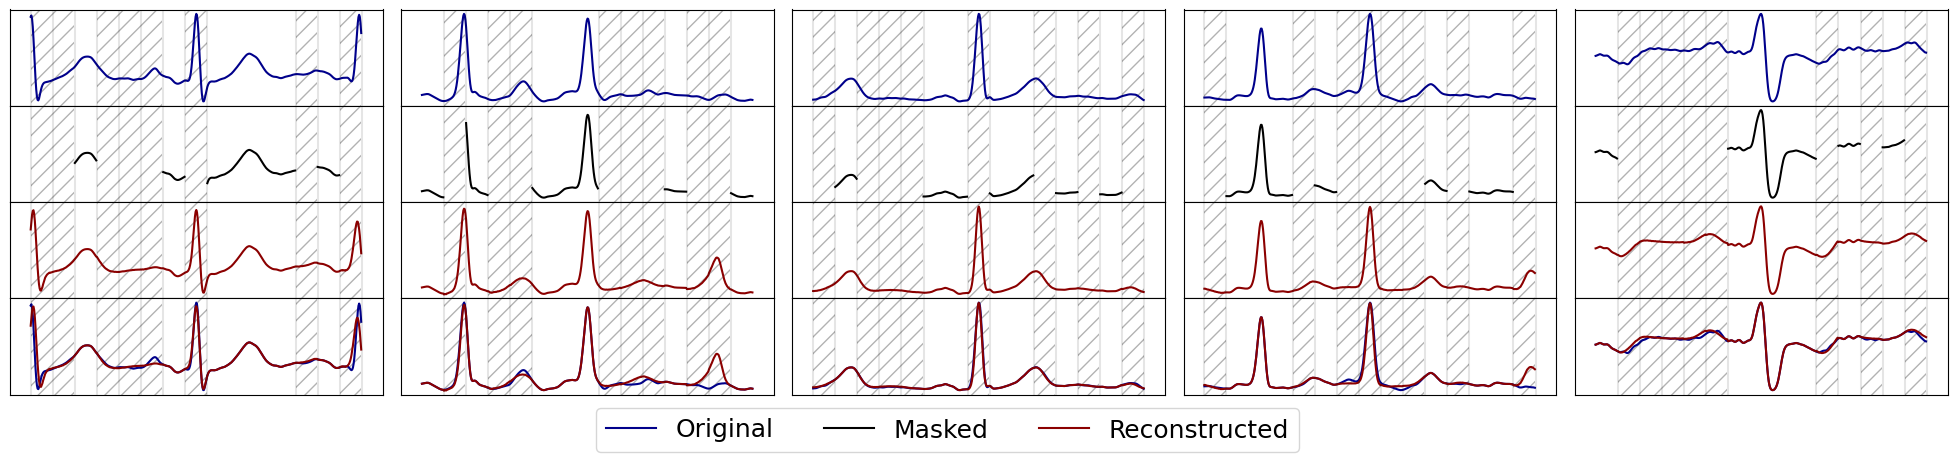

In [14]:
dataset = torch.load("../storage/ssd/public/guoxin/maecg/mitdb_inter/af_beat_4_train.pth")
index = [random.randint(0, len(dataset) - 1) for _ in range(5)]

fig = plt.figure(figsize=(25, 5))
axes = fig.subplots(nrows=4, ncols=5)
for i in range(5):
    masked_input, plot_ori, plot_masked, plot_recon, lines = recon(
        model, dataset[index[i]][0], 0.5, 32
    )
    plot_one_recon(axes, i, masked_input, plot_ori, plot_masked, plot_recon, lines)
lines = []
labels = []
axLine, axLabel = axes[0][0].get_legend_handles_labels()
lines.extend(axLine)
labels.extend(axLabel)
axLine, axLabel = axes[1][0].get_legend_handles_labels()
lines.extend(axLine)
labels.extend(axLabel)
axLine, axLabel = axes[2][0].get_legend_handles_labels()
lines.extend(axLine)
labels.extend(axLabel)

lgd = fig.legend(
    lines,
    labels,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.03),
    ncol=3,
    prop={"size": 18},
)
fig.subplots_adjust(hspace=0, wspace=0.05)
fig.savefig(
    "./test_output/rec_exp_diff.pdf",
    dpi=1200,
    bbox_extra_artists=(lgd,),
    bbox_inches="tight",
)
plt.show()

### Ablation Reconstruction

In [ ]:
def plot_one_mul(fig, row, gses, data, is_last):
    _, plot_ori, plot_masked, plot_recon, _ = data[0]

    ax = fig.add_subplot(gses[row, 0])
    ax.plot(plot_ori, "darkblue", label="Original")
    ax.set_xlim([-30, 510])
    ax.set_ylim([-1.1, 1.1])
    if row == gses.nrows - 1 and is_last:
        ax.set_xlabel("Original", fontsize=11)
    ax.set_xticks([])
    ax.set_yticks([])

    for idx in range(1, gses.ncols // 2 + 1):
        _, plot_ori, plot_masked, plot_recon, _ = data[idx - 1]
        if row == gses.nrows - 1 and is_last:
            ax = fig.add_subplot(gses[row, 2 * idx - 1 : 2 * idx + 1])
            ax.set_xlabel(f"Mask {idx*20+10}%", fontsize=11)
            ax.set_xticks([])
            ax.set_yticks([])
        gs0 = gses[row, 2 * idx - 1 : 2 * idx + 1].subgridspec(1, 2, wspace=0)
        ax = fig.add_subplot(gs0[0])
        ax.plot(plot_masked, "k", label="Masked")
        ax.set_xlim([-30, 510])
        ax.set_ylim([-1.1, 1.1])
        ax.set_xticks([])
        ax.set_yticks([])

        ax = fig.add_subplot(gs0[1])
        ax.plot(plot_ori, "darkblue", label="Original")
        ax.plot(plot_recon, "darkred", label="Reconstructed")
        ax.set_xlim([-30, 510])
        ax.set_ylim([-1.1, 1.1])
        ax.set_xticks([])
        ax.set_yticks([])

#### Configuration

In [ ]:
model_arch = []
model = mae_vit_small_patch32(signal_length=480).to("cuda")
model.load_state_dict(
    torch.load(
        "/home/guoxin/mae/pretrains/output/mae_vit_small_p32_m50_ep500/checkpoint-499.pth"
    )["model"]
)
model_arch.append(model)
model = mae_vit_base_patch32(signal_length=480).to("cuda")
model.load_state_dict(
    torch.load(
        "/home/guoxin/mae/pretrains/output/mae_vit_base_p32_m50_ep500/checkpoint-499.pth"
    )["model"]
)
model_arch.append(model)
model = mae_vit_large_patch32(signal_length=480).to("cuda")
model.load_state_dict(
    torch.load(
        "/home/guoxin/mae/pretrains/output/mae_vit_large_p32_m50_ep200/checkpoint-199.pth"
    )["model"]
)
model_arch.append(model)

model_mask_ratio = []
model = mae_vit_base_patch32(signal_length=480).to("cuda")
model.load_state_dict(
    torch.load(
        "/home/guoxin/mae/pretrains/output/mae_vit_base_p32_m30_ep500/checkpoint-499.pth"
    )["model"]
)
model_mask_ratio.append(model)
model = mae_vit_base_patch32(signal_length=480).to("cuda")
model.load_state_dict(
    torch.load(
        "/home/guoxin/mae/pretrains/output/mae_vit_base_p32_m50_ep500/checkpoint-499.pth"
    )["model"]
)
model_mask_ratio.append(model)
model = mae_vit_base_patch32(signal_length=480).to("cuda")
model.load_state_dict(
    torch.load(
        "/home/guoxin/mae/pretrains/output/mae_vit_base_p32_m70_ep500/checkpoint-499.pth"
    )["model"]
)
model_mask_ratio.append(model)

model_patch_size = []
model = mae_vit_base_patch2(signal_length=480).to("cuda")
model.load_state_dict(
    torch.load(
        "/home/guoxin/mae/pretrains/output/mae_vit_base_p2_m50_ep500/checkpoint-499.pth"
    )["model"]
)
model_patch_size.append(model)
model = mae_vit_base_patch8(signal_length=480).to("cuda")
model.load_state_dict(
    torch.load(
        "/home/guoxin/mae/pretrains/output/mae_vit_base_p8_m50_ep500/checkpoint-499.pth"
    )["model"]
)
model_patch_size.append(model)
model = mae_vit_base_patch32(signal_length=480).to("cuda")
model.load_state_dict(
    torch.load(
        "/home/guoxin/mae/pretrains/output/mae_vit_base_p32_m50_ep500/checkpoint-499.pth"
    )["model"]
)
model_patch_size.append(model)

model_sizes = ["Small", "Base", "Large"]
patch_sizes = [2, 8, 32]
dataset = torch.load("../storage/ssd/public/guoxin/mitdb/af_beat_train.pth")

#### Multiple Mask Ratio

In [ ]:
index = [19143, 19403, 34331]
seeds = [
    6638900529601977669,
    16983372241755870900,
    13155893578625606940,
    14825555800377191828,
    16006822260222031862,
    9698232877625497,
    12287100323021921755,
    11824538758466494427,
    8468881086988104669,
    14436294109023046365,
    11146063689755352779,
    7759430015157451189,
    1569636882349774638,
    15399763259163969173,
    14586208716157339788,
    10899464876873541326,
    18351482007935432989,
    13214021109747214251,
    1347349082000158941,
    3480963155389737497,
    5845246706247432591,
    2071851818138332462,
    14033939734181519936,
    3322327996817333384,
    4160367335080598070,
    18303688755862026454,
    16704840165857496834,
]

fig = plt.figure(figsize=(10, 5))
gses = fig.add_gridspec(nrows=3, ncols=1, hspace=0.15)
for i, gs in enumerate(gses):
    ax = fig.add_subplot(gs)
    ax.set_ylabel(f"Mask Ratio {i*20+30}%", fontsize=11)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    gs_sample = gs.subgridspec(nrows=3, ncols=7, hspace=0.125, wspace=0.05)
    for row in range(gs_sample.nrows):
        data = []
        torch.manual_seed(
            seeds[i * gses.nrows * gs_sample.nrows + row * gs_sample.nrows + 0]
        )
        data.append(recon(model_mask_ratio[i], dataset, index[row], 0.3, 32))
        torch.manual_seed(
            seeds[i * gses.nrows * gs_sample.nrows + row * gs_sample.nrows + 1]
        )
        data.append(recon(model_mask_ratio[i], dataset, index[row], 0.5, 32))
        torch.manual_seed(
            seeds[i * gses.nrows * gs_sample.nrows + row * gs_sample.nrows + 2]
        )
        data.append(recon(model_mask_ratio[i], dataset, index[row], 0.7, 32))
        if i == gses.nrows - 1:
            plot_one_mul(fig, row, gs_sample, data, True)
        else:
            plot_one_mul(fig, row, gs_sample, data, False)

lines = []
labels = []
axLine, axLabel = fig.axes[-4].get_legend_handles_labels()
lines.append(axLine[0])
labels.append(axLabel[0])
axLine, axLabel = fig.axes[-2].get_legend_handles_labels()
lines.append(axLine[0])
labels.append(axLabel[0])
axLine, axLabel = fig.axes[-1].get_legend_handles_labels()
lines.append(axLine[1])
labels.append(axLabel[1])

lgd = fig.legend(
    lines,
    labels,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.03),
    ncol=4,
    prop={"size": 13.5},
)
fig.savefig(
    "./test_output/mul_ratio.pdf",
    dpi=1200,
    bbox_extra_artists=(lgd,),
    bbox_inches="tight",
)
plt.show()

#### Multiple Patch Size

In [ ]:
index = [4582, 12, 512]
seeds = [
    6638900529601977669,
    16983372241755870900,
    13155893578625606940,
    14825555800377191828,
    16006822260222031862,
    9698232877625497,
    12287100323021921755,
    11824538758466494427,
    8468881086988104669,
    14436294109023046365,
    11146063689755352779,
    7759430015157451189,
    1569636882349774638,
    15399763259163969173,
    14586208716157339788,
    10899464876873541326,
    18351482007935432989,
    13214021109747214251,
    1347349082000158941,
    16625455711323205250,
    5845246706247432591,
    2071851818138332462,
    14033939734181519936,
    11858561295810312548,
    4160367335080598070,
    13353474577307756186,
    11889279793219525005,
]

fig = plt.figure(figsize=(10, 5))
gses = fig.add_gridspec(nrows=3, ncols=1, hspace=0.15)
for i, gs in enumerate(gses):
    ax = fig.add_subplot(gs)
    ax.set_ylabel(f"Patch Size {2**(2*i+1)}", fontsize=11)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    gs_sample = gs.subgridspec(nrows=3, ncols=7, hspace=0.125, wspace=0.05)
    for row in range(gs_sample.nrows):
        data = []
        torch.manual_seed(
            seeds[i * gses.nrows * gs_sample.nrows + row * gs_sample.nrows + 0]
        )
        data.append(
            recon(model_patch_size[i], dataset, index[row], 0.3, patch_sizes[i])
        )
        torch.manual_seed(
            seeds[i * gses.nrows * gs_sample.nrows + row * gs_sample.nrows + 1]
        )
        data.append(
            recon(model_patch_size[i], dataset, index[row], 0.5, patch_sizes[i])
        )
        torch.manual_seed(
            seeds[i * gses.nrows * gs_sample.nrows + row * gs_sample.nrows + 2]
        )
        data.append(
            recon(model_patch_size[i], dataset, index[row], 0.7, patch_sizes[i])
        )
        if i == gses.nrows - 1:
            plot_one_mul(fig, row, gs_sample, data, True)
        else:
            plot_one_mul(fig, row, gs_sample, data, False)

lines = []
labels = []
axLine, axLabel = fig.axes[-4].get_legend_handles_labels()
lines.append(axLine[0])
labels.append(axLabel[0])
axLine, axLabel = fig.axes[-2].get_legend_handles_labels()
lines.append(axLine[0])
labels.append(axLabel[0])
axLine, axLabel = fig.axes[-1].get_legend_handles_labels()
lines.append(axLine[1])
labels.append(axLabel[1])

lgd = fig.legend(
    lines,
    labels,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.03),
    ncol=4,
    prop={"size": 13.5},
)
fig.savefig(
    "./test_output/mul_patch.pdf",
    dpi=1200,
    bbox_extra_artists=(lgd,),
    bbox_inches="tight",
)
plt.show()

#### Multiple Model Size

In [ ]:
index = [1000, 21354, 1235]
seeds = [
    5800758943687963315,
    15487478413585449412,
    16482946909983974614,
    10279449139877891546,
    15305697550022141482,
    4244877253185457109,
    8544699289582484863,
    1071407844255583447,
    2971366124203195537,
    11525591010501525474,
    7627702483614320916,
    18019721501608808163,
    18043274282063314494,
    390182374384992831,
    8237747841057969106,
    18380471247033127213,
    1576992552438986495,
    17517904687719823806,
    11015722358733064354,
    5679123318177788652,
    7903555596619673431,
    6672879470489436725,
    17520511656084568376,
    15665385405327921893,
    14634072519553003615,
    7976039451801557605,
    5180771240268562069,
]

fig = plt.figure(figsize=(10, 5))
gses = fig.add_gridspec(nrows=3, ncols=1, hspace=0.15)
for i, gs in enumerate(gses):
    ax = fig.add_subplot(gs)
    ax.set_ylabel(model_sizes[i], fontsize=11)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    gs_sample = gs.subgridspec(nrows=3, ncols=7, hspace=0.125, wspace=0.05)
    for row in range(gs_sample.nrows):
        data = []
        torch.manual_seed(
            seeds[i * gses.nrows * gs_sample.nrows + row * gs_sample.nrows + 0]
        )
        data.append(recon(model_arch[i], dataset, index[row], 0.3, 32))
        torch.manual_seed(
            seeds[i * gses.nrows * gs_sample.nrows + row * gs_sample.nrows + 1]
        )
        data.append(recon(model_arch[i], dataset, index[row], 0.5, 32))
        torch.manual_seed(
            seeds[i * gses.nrows * gs_sample.nrows + row * gs_sample.nrows + 2]
        )
        data.append(recon(model_arch[i], dataset, index[row], 0.7, 32))
        if i == gses.nrows - 1:
            plot_one_mul(fig, row, gs_sample, data, True)
        else:
            plot_one_mul(fig, row, gs_sample, data, False)

lines = []
labels = []
axLine, axLabel = fig.axes[-4].get_legend_handles_labels()
lines.append(axLine[0])
labels.append(axLabel[0])
axLine, axLabel = fig.axes[-2].get_legend_handles_labels()
lines.append(axLine[0])
labels.append(axLabel[0])
axLine, axLabel = fig.axes[-1].get_legend_handles_labels()
lines.append(axLine[1])
labels.append(axLabel[1])

lgd = fig.legend(
    lines,
    labels,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.03),
    ncol=4,
    prop={"size": 13.5},
)
fig.savefig(
    "./test_output/mul_model.pdf",
    dpi=1200,
    bbox_extra_artists=(lgd,),
    bbox_inches="tight",
)
plt.show()

## AF

### Data Distribution

In [17]:
incart = []
incart.extend(torch.load("../storage/ssd/public/guoxin/maecg/incartdb/af_beat_4_train.pth").get_labels())
incart.extend(torch.load("../storage/ssd/public/guoxin/maecg/incartdb/af_beat_4_valid.pth").get_labels())
incart.extend(torch.load("../storage/ssd/public/guoxin/maecg/incartdb/af_beat_4_test.pth").get_labels())
print("INCART: ", dict(Counter(incart)))
mit_train = torch.load("../storage/ssd/public/guoxin/maecg/mitdb_inter/af_beat_4_train.pth").get_labels()
print("MIT train: ", dict(Counter(mit_train)))
mit_valid = torch.load("../storage/ssd/public/guoxin/maecg/mitdb_inter/af_beat_4_valid.pth").get_labels()
print("MIT valid: ", dict(Counter(mit_valid)))
mit_test = torch.load("../storage/ssd/public/guoxin/maecg/mitdb_inter/af_beat_4_test.pth").get_labels()
print("MIT test: ", dict(Counter(mit_test)))

INCART:  {0: 153563, 2: 20000, 1: 1958, 3: 219}
MIT train:  {2: 3386, 0: 42944, 3: 376, 1: 847}
MIT valid:  {0: 4746, 2: 401, 1: 99, 3: 38}
MIT test:  {0: 44225, 1: 1837, 2: 3219, 3: 388}


## AU

### Data Distribution

In [18]:
ecgid_train = torch.load("../storage/ssd/public/guoxin/maecg/ecgiddb/au_beat_train.pth").get_labels()
print("ECGID train: ", (dict(Counter(ecgid_train))))
ecgid_valid = torch.load("../storage/ssd/public/guoxin/maecg/ecgiddb/au_beat_valid.pth").get_labels()
print("ECGID valid: ", (dict(Counter(ecgid_valid))))
ecgid_test = torch.load("../storage/ssd/public/guoxin/maecg/ecgiddb/au_beat_test.pth").get_labels()
print("ECGID test: ", (dict(Counter(ecgid_test))))

ECGID train:  {28: 39, 29: 61, 46: 31, 47: 37, 52: 69, 34: 73, 35: 62, 41: 58, 72: 24, 43: 35, 10: 42, 37: 30, 48: 35, 1: 307, 24: 66, 15: 44, 50: 43, 73: 12, 30: 36, 53: 23, 11: 36, 68: 39, 0: 294, 81: 26, 69: 40, 51: 185, 61: 40, 64: 34, 63: 33, 76: 56, 23: 71, 62: 66, 9: 80, 58: 78, 17: 30, 67: 33, 39: 60, 66: 39, 25: 50, 57: 26, 33: 89, 3: 26, 8: 84, 83: 45, 82: 30, 49: 31, 27: 66, 2: 66, 89: 34, 87: 39, 36: 19, 60: 73, 75: 50, 31: 69, 18: 31, 5: 26, 56: 51, 21: 24, 77: 33, 84: 45, 85: 39, 71: 126, 59: 43, 4: 25, 19: 45, 22: 18, 79: 34, 74: 48, 12: 30, 54: 26, 45: 79, 78: 24, 86: 35, 88: 26, 26: 43, 70: 72, 14: 25, 42: 26, 16: 26, 32: 30, 65: 33, 40: 19, 55: 28, 44: 31, 6: 31, 80: 28, 7: 29, 20: 45, 13: 38, 38: 25}
ECGID valid:  {6: 5, 79: 10, 1: 101, 26: 10, 50: 17, 64: 13, 80: 6, 0: 93, 40: 13, 70: 29, 76: 25, 60: 16, 31: 26, 45: 34, 27: 25, 51: 61, 53: 11, 4: 5, 2: 26, 85: 12, 20: 18, 62: 31, 46: 11, 29: 16, 3: 9, 59: 19, 71: 45, 52: 32, 74: 25, 35: 25, 69: 13, 41: 23, 34: 26, 5

## DN

In [19]:
def denoise(model, dataset, index):
    wn = dataset.signals_wn[index]
    won = dataset.signals_won[index]
    latent, _, ids_restore = model.forward_encoder(wn.unsqueeze(0).unsqueeze(0).cuda(), 0)
    pred = model.forward_decoder(latent, ids_restore)
    pred_unpatchified = model.unpatchify(pred).squeeze()
    plot_denoise = pred_unpatchified.detach().cpu().numpy()
    return won[0], wn[0], plot_denoise


def plot_one_denoise(axes, col, plot_target, plot_input, plot_denoise):
    axes[0][col].plot(
        plot_target, "darkblue", label="Target".center(20) + "\n" "(Without Noise)"
    )
    axes[0][col].set_xlim([-30, 510])
    axes[0][col].set_ylim([-1.1, 1.1])
    axes[0][col].set_xticks([])
    axes[0][col].set_yticks([])
    axes[1][col].plot(plot_input, "k", label="Input".center(16) + "\n" + "(With Noise)")
    axes[1][col].set_xlim([-30, 510])
    axes[1][col].set_ylim([-1.1, 1.1])
    axes[1][col].set_xticks([])
    axes[1][col].set_yticks([])
    axes[2][col].plot(
        plot_denoise, "darkred", label="Output".center(12) + "\n" + "(Denoised)"
    )
    axes[2][col].set_xlim([-30, 510])
    axes[2][col].set_ylim([-1.1, 1.1])
    axes[2][col].set_xticks([])
    axes[2][col].set_yticks([])
    axes[3][col].plot(
        plot_target, "darkblue", label="Target".center(20) + "\n" "(Without Noise)"
    )
    axes[3][col].plot(
        plot_denoise, "darkred", label="Output".center(12) + "\n" + "(Denoised)"
    )
    axes[3][col].set_xlim([-30, 510])
    axes[3][col].set_ylim([-1.1, 1.1])
    axes[3][col].set_xticks([])
    axes[3][col].set_yticks([])

### Configuration

In [ ]:
model = mae_vit_base_patch32(signal_length=480).to("cuda")
ckpt = torch.load(
    "/home/guoxin/mae/finetunes/dn_beat/output/mae_vit_base_p32_m50_ep200_bs32/checkpoint-199.pth"
)
model.load_state_dict(ckpt["model"])
dataset = torch.load("../storage/ssd/public/guoxin/ecgiddb/dn_beat_test.pth")

In [ ]:
index = [1815, 1231, 731, 1757]
fig = plt.figure(figsize=(20, 5))
axes = fig.subplots(nrows=4, ncols=4)
for i in range(4):
    plot_target, plot_input, plot_denoise = denoise(model, dataset, index[i])
    plot_one_denoise(axes, i, plot_target, plot_input, plot_denoise)
lines = []
labels = []
axLine, axLabel = axes[0][0].get_legend_handles_labels()
lines.extend(axLine)
labels.extend(axLabel)
axLine, axLabel = axes[1][0].get_legend_handles_labels()
lines.extend(axLine)
labels.extend(axLabel)
axLine, axLabel = axes[2][0].get_legend_handles_labels()
lines.extend(axLine)
labels.extend(axLabel)
lgd = fig.legend(
    lines,
    labels,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.075),
    ncol=3,
    prop={"size": 18},
)
fig.subplots_adjust(hspace=0, wspace=0.05)
fig.savefig(
    "./test_output/3_dn_exp.pdf",
    dpi=1200,
    bbox_extra_artists=(lgd,),
    bbox_inches="tight",
)
plt.show()

## Feature Map

In [ ]:
def attn_forward(attn_module, x):
    B, N, C = x.shape
    qkv = (
        attn_module.qkv(x)
        .reshape(B, N, 3, attn_module.num_heads, C // attn_module.num_heads)
        .permute(2, 0, 3, 1, 4)
    )
    q, k, v = qkv[0], qkv[1], qkv[2]
    attn = (q @ k.transpose(-2, -1)) * attn_module.scale
    attn = attn.softmax(dim=-1)
    attn = attn_module.attn_drop(attn)
    x = (attn @ v).transpose(1, 2).reshape(B, N, C)
    x = attn_module.proj(x)
    x = attn_module.proj_drop(x)
    return x, attn


def get_selfattention(model, signals):
    x = model.patch_embed(signals)
    x = x + model.pos_embed
    for i, blk in enumerate(model.blocks):
        if i == len(model.blocks) - 1:
            _, last_attn = attn_forward(blk.attn, blk.norm1(x))
        x = blk(x)
    return last_attn


def plot_attn(input, ps, fig, gs, models):
    w_featmap = input.shape[-1] // ps
    attentions = []
    for model in models:
        attention = get_selfattention(model, input.cuda())
        nh = attention.shape[1]
        attention = attention[0, :, 0, :].reshape(nh, -1)
        attention = attention.reshape(nh, w_featmap)
        attention = (
            F.interpolate(attention.unsqueeze(0), scale_factor=ps, mode="linear")[0]
            .cpu()
            .detach()
            .numpy()
        )
        attention = attention.sum(axis=0) / nh
        attentions.append(attention)
    gs_sub = gs.subgridspec(len(models) + 1, 1, hspace=0)
    ax = fig.add_subplot(gs_sub[0])
    ax.plot(input[0][0], color='darkblue')
    ax.set_xticks([])
    ax.set_yticks([])
    for i in range(1, len(models) + 1):
        ax = fig.add_subplot(gs_sub[i])
        ax.imshow(
            attentions[i - 1].reshape(1, len(attentions[i - 1])),
            cmap="plasma",
            aspect="auto",
        )
        ax.set_xticks([])
        ax.set_yticks([])

### Configuration

In [ ]:
dataset = torch.load("../storage/ssd/public/guoxin/mitdb/af_beat_train.pth")
model_arch = [
    vit_small_p32(signal_length=480).to("cuda"),
    vit_base_p32(signal_length=480).to("cuda"),
    vit_large_p32(signal_length=480).to("cuda"),
]
checkpoint_model_arch = [
    torch.load(
        f"/home/guoxin/mae/pretrains/output/mae_vit_small_p32_m50_ep500/checkpoint-499.pth"
    )["model"],
    torch.load(
        f"/home/guoxin/mae/pretrains/output/mae_vit_base_p32_m50_ep500/checkpoint-499.pth"
    )["model"],
    torch.load(
        f"/home/guoxin/mae/pretrains/output/mae_vit_large_p32_m50_ep200/checkpoint-199.pth"
    )["model"],
]
for i, model in enumerate(model_arch):
    state_dict = model.state_dict()
    for k in checkpoint_model_arch[i].copy().keys():
        if (
            k.startswith("head")
            and checkpoint_model_arch[i][k].shape != state_dict[k].shape
        ):
            print(f"Removing key {k} from checkpoint")
            del checkpoint_model_arch[i][k]
    interpolate_pos_embed(model, checkpoint_model_arch[i])
    model.load_state_dict(checkpoint_model_arch[i], strict=False)

model_super = [
    vit_base_p32(signal_length=480).to("cuda"),
    vit_base_p32(signal_length=480).to("cuda"),
    vit_base_p32(signal_length=480).to("cuda"),
    vit_base_p32(signal_length=480).to("cuda"),
]
checkpoint_model_super = [
    torch.load(
        f"/home/guoxin/mae/superviseds/af_beat/output/vit_base_p32_ep200_bs1024/checkpoint-max_acc.pth"
    )["model"],
    torch.load(
        f"/home/guoxin/mae/superviseds/au_beat/output/vit_base_p32_ep200_bs32/checkpoint-max_acc.pth"
    )["model"],
    torch.load(
        f"/home/guoxin/mae/superviseds/dn_beat/output/mae_vit_base_p32_ep200_bs32/checkpoint-199.pth"
    )["model"],
    torch.load(
        f"/home/guoxin/mae/pretrains/output/mae_vit_base_p32_m50_ep500/checkpoint-499.pth"
    )["model"],
]
for i, model in enumerate(model_super):
    state_dict = model.state_dict()
    for k in checkpoint_model_super[i].copy().keys():
        if (
            k.startswith("head")
            and checkpoint_model_super[i][k].shape != state_dict[k].shape
        ):
            print(f"Removing key {k} from checkpoint")
            del checkpoint_model_super[i][k]
    interpolate_pos_embed(model, checkpoint_model_super[i])
    model.load_state_dict(checkpoint_model_super[i], strict=False)


patch_sizes = 32

### Feature Analysis

In [ ]:
index = [15691, 31498, 46442, 44462, 41222, 47428, 7316, 28929]
fig = plt.figure(figsize=(15, 6))
gses = fig.add_gridspec(nrows=2, ncols=4, hspace=0.05, wspace=0.05)
for i, gs in enumerate(gses):
    plot_attn(dataset[index[i]][0].unsqueeze(0), 32, fig, gs, model_super)
plt.colorbar(cm.ScalarMappable(cmap="plasma"), ax=fig.axes, location="bottom", shrink=0.4, anchor=(0.5, 2))


fig.savefig(
    "./test_output/feature_analysis.pdf",
    dpi=1200,
    bbox_inches="tight",
)
plt.show()

### Multiple Model Size

In [ ]:
idx = 1000
input = dataset[idx][0].unsqueeze(0)
w_featmap = input.shape[-1] // 32

attentions = []
for model in model_arch:
    attention = get_selfattention(model, input.cuda())
    nh = attention.shape[1]
    attention = attention[0, :, 0, :].reshape(nh, -1)
    attention = attention.reshape(nh, w_featmap)
    attention = (
        F.interpolate(attention.unsqueeze(0), scale_factor=32, mode="linear")[0]
        .cpu()
        .detach()
        .numpy()
    )
    attention = attention.sum(axis=0) / nh
    attentions.append(attention)

fig = plt.figure()
axes = fig.subplots(nrows=4, ncols=1)
for i, ax in enumerate(axes):
    if i == 0:
        ax.plot(input[0][0])
    else:
        ax.imshow(
            attentions[i - 1].reshape(1, len(attentions[i - 1])),
            cmap="plasma",
            aspect="auto",
        )
    ax.set_xticks([])
    ax.set_yticks([])

fig.subplots_adjust(hspace=0, wspace=0)
fig.savefig(
    "./test_output/att_map.pdf",
    dpi=1200,
    bbox_inches="tight",
)
plt.show()

## Other Figure

### Mask Ratio

In [ ]:
af = [92.6, 93.4, 95.3, 95.4, 95.6, 95.3, 95.3, 95.2, 90.3]
id = [69.4, 73.4, 97.9, 98.5, 98.8, 98.7, 98.0, 96.5, 38.5]
mask_ratio = [0, 0.625, 1.25, 1.875, 2.5, 3.125, 3.75, 4.375, 5]

fig = plt.figure(figsize=(6.4, 4.8))
fig.text(0.05, 0.5, "Accuracy (%)", va="center", rotation="vertical", fontsize=12)
fig.text(0.5, 0.025, "Mask Ratio (%)", ha="center", fontsize=12)

axes = fig.subplots(nrows=2, ncols=1)
axes[0].spines["right"].set_visible(False)
axes[0].spines["top"].set_visible(False)
axes[0].plot(
    mask_ratio, af, color="darkred", marker="*", label="Arrhythmia\nClassification"
)
for a, b in zip(mask_ratio, af):
    axes[0].text(a, b + 0.1, b, ha="center", va="bottom", fontsize=12)
axes[0].hlines(
    y=[90, 91, 92, 93, 94, 95, 96], xmin=-0.5, xmax=5.5, color="black", alpha=0.1
)
axes[0].set_xticks([])
axes[0].set_xlim([-0.5, 5.5])
axes[0].set_yticks(
    [90, 91, 92, 93, 94, 95, 96], [90, 91, 92, 93, 94, 95, 96], fontsize=12
)
axes[0].set_ylim([89.5, 96.5])
axes[0].legend(loc="lower left", fontsize=12)

axes[1].spines["right"].set_visible(False)
axes[1].spines["top"].set_visible(False)
axes[1].plot(
    mask_ratio, id, color="darkblue", marker="*", label="Human\nIdentification"
)
for a, b in zip(mask_ratio, id):
    axes[1].text(a, b + 1.1, b, ha="center", va="bottom", fontsize=12)
axes[1].hlines(
    y=[40, 50, 60, 70, 80, 90, 100], xmin=-0.5, xmax=5.5, color="black", alpha=0.1
)
axes[1].set_xticks(mask_ratio, [10, 20, 30, 40, 50, 60, 70, 80, 90], fontsize=12)
axes[1].set_xlim([-0.5, 5.5])
axes[1].set_yticks(
    [40, 50, 60, 70, 80, 90, 100], [40, 50, 60, 70, 80, 90, 100], fontsize=12
)
axes[1].set_ylim([35, 105])
axes[1].legend(loc="lower left", fontsize=12)

fig.subplots_adjust(hspace=0.1, wspace=0)
fig.savefig(
    "./test_output/diff_mask_ratio.pdf",
    dpi=1200,
    bbox_inches="tight",
)
plt.show()

### Patch Size

In [ ]:
af = [93.8, 94.5, 94.7, 95.1, 95.6, 94.1]
id = [88.7, 92.6, 95.5, 98.4, 98.8, 95.7]
patch_size = range(6)

fig = plt.figure(figsize=(6.4, 4.8))
fig.text(0.025, 0.5, "Accuracy (%)", va="center", rotation="vertical", fontsize=12)
fig.text(0.5, 0.025, "Patch Size", ha="center", fontsize=12)

axes = fig.subplots(nrows=2, ncols=1)
axes[0].spines["right"].set_visible(False)
axes[0].spines["top"].set_visible(False)
axes[0].plot(
    patch_size, af, color="darkred", marker="*", label="Arrhythmia\nClassification"
)
for a, b in zip(patch_size, af):
    axes[0].text(a, b + 0.05, b, ha="center", va="bottom", fontsize=12)
axes[0].hlines(
    y=[93.5, 94, 94.5, 95, 95.5, 96], xmin=-100, xmax=100, color="black", alpha=0.1
)
axes[0].set_xticks([])
axes[0].set_xlim([-0.5, 5.5])
axes[0].set_yticks(
    [93.5, 94.0, 94.5, 95.0, 95.5, 96.0], [93.5, 94.0, 94.5, 95.0, 95.5, 96.0], fontsize=12
)
axes[0].set_ylim([93.25, 96.25])
axes[0].legend(loc="upper left", fontsize=12)

axes[1].spines["right"].set_visible(False)
axes[1].spines["top"].set_visible(False)
axes[1].plot(
    patch_size, id, color="darkblue", marker="*", label="Human\nIdentification"
)
for a, b in zip(patch_size, id):
    axes[1].text(a, b + 0.25, b, ha="center", va="bottom", fontsize=12)
axes[1].hlines(
    y=[89.0, 91.5, 94.0, 96.5, 99.0], xmin=-100, xmax=100, color="black", alpha=0.1
)
axes[1].set_xticks(patch_size, ["2", "4", "8", "16", "32", "96"], fontsize=12)
axes[1].set_xlim([-0.5, 5.5])
axes[1].set_yticks(
    [89.0, 91.5, 94.0, 96.5, 99.0], [89.0, 91.5, 94.0, 96.5, 99.0], fontsize=12
)
axes[1].set_ylim([87.75, 100.25])
axes[1].legend(loc="upper left", fontsize=12)

fig.subplots_adjust(hspace=0.1, wspace=0)
fig.savefig(
    "./test_output/diff_patch_size.pdf",
    dpi=1200,
    bbox_inches="tight",
)
plt.show()

### Model Size

In [ ]:
af = [93.3, 93.4, 94.0, 95.6, 95.4, 95.4]
id = [94.1, 97.1, 98.7, 98.8, 98.5, 98.3]
model_size = range(6)

fig = plt.figure(figsize=(6.4, 4.8))
fig.text(0.025, 0.5, "Accuracy (%)", va="center", rotation="vertical", fontsize=12)
fig.text(0.5, 0.025, "Model Size", ha="center", fontsize=12)

axes = fig.subplots(nrows=2, ncols=1)
axes[0].spines["right"].set_visible(False)
axes[0].spines["top"].set_visible(False)
axes[0].plot(
    model_size, af, color="darkred", marker="*", label="Arrhythmia\nClassification"
)
for a, b in zip(model_size, af):
    axes[0].text(a, b + 0.05, b, ha="center", va="bottom", fontsize=12)
axes[0].hlines(
    y=[93.0, 93.5, 94.0, 94.5, 95.0, 95.5, 96.0],
    xmin=-100,
    xmax=100,
    color="black",
    alpha=0.1,
)
axes[0].set_xticks([])
axes[0].set_xlim([-0.5, 5.5])
axes[0].set_yticks(
    [93.0, 93.5, 94.0, 94.5, 95.0, 95.5, 96.0],
    [93.0, 93.5, 94.0, 94.5, 95.0, 95.5, 96.0],
    fontsize=12,
)
axes[0].set_ylim([92.75, 96.25])
axes[0].legend(loc="lower right", fontsize=12)

axes[1].spines["right"].set_visible(False)
axes[1].spines["top"].set_visible(False)
axes[1].plot(
    model_size, id, color="darkblue", marker="*", label="Human\nIdentification"
)
for a, b in zip(model_size, id):
    axes[1].text(a, b + 0.1, b, ha="center", va="bottom", fontsize=12)
axes[1].hlines(
    y=[94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0],
    xmin=-100,
    xmax=100,
    color="black",
    alpha=0.1,
)
axes[1].set_xticks(
    model_size, ["Atto", "Tiny", "Small", "Base", "Large", "Huge"], fontsize=12
)
axes[1].set_xlim([-0.5, 5.5])
axes[1].set_yticks(
    [94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0],
    [94, 95, 96, 97, 98, 99, 100],
    fontsize=12,
)
axes[1].set_ylim([93.5, 100.5])
axes[1].legend(loc="lower right", fontsize=12)

fig.subplots_adjust(hspace=0.1, wspace=0)
fig.savefig(
    "./test_output/diff_model_size.pdf",
    dpi=1200,
    bbox_inches="tight",
)
plt.show()

### Eval

In [ ]:
def eval(data_loader_test, class_index=None):
    target = []
    output = []
    for _, batch in enumerate(data_loader_test):
        signal = batch[0]
        target.extend(batch[-1].detach().cpu().numpy())
        if not isinstance(signal, list):
            signal = signal.to("cuda", non_blocking=True)
        if len(signal.shape) == 2:
            signal = signal.unsqueeze(1)
        with torch.cuda.amp.autocast():
            if class_index:
                temp = model(signal).softmax(-1)[:, class_index]
            else:
                temp = model(signal).softmax(-1).argmax(-1)
            output.extend(temp.detach().cpu().numpy())
    return np.array(target), np.array(output)

#### Configuration

In [ ]:
model = vit_base_p32(mlp_sizes=[5]).to("cuda")
model.load_state_dict(
    torch.load(
        "/home/guoxin/mae/finetunes/af_beat/output/vit_base_p32_m50_ep200_bs1024/checkpoint-max_acc.pth"
    )["model"]
)

mit1_dataset = torch.utils.data.ConcatDataset(
    [
        torch.load("../storage/ssd/public/guoxin/mitdb/af_beat_train.pth"),
        torch.load("../storage/ssd/public/guoxin/mitdb/af_beat_valid.pth"),
    ]
)
data_loader_mit1 = torch.utils.data.DataLoader(
    mit1_dataset,
    sampler=torch.utils.data.SequentialSampler(mit1_dataset),
    batch_size=1024,
    num_workers=20,
    pin_memory=True,
    drop_last=False,
)
mit2_dataset = torch.load("../storage/ssd/public/guoxin/mitdb/af_beat_test.pth")
data_loader_mit2 = torch.utils.data.DataLoader(
    mit2_dataset,
    sampler=torch.utils.data.SequentialSampler(mit2_dataset),
    batch_size=1024,
    num_workers=20,
    pin_memory=True,
    drop_last=False,
)
incart_dataset = torch.load("../storage/ssd/public/guoxin/incartdb/af_beat.pth")
data_loader_incart = torch.utils.data.DataLoader(
    incart_dataset,
    sampler=torch.utils.data.SequentialSampler(incart_dataset),
    batch_size=1024,
    num_workers=20,
    pin_memory=True,
    drop_last=False,
)

#### ROC

In [ ]:
class_idx = 4
class_name = ["N", "SVEB", "VEB", "F", "Q"]

plt.figure(figsize=(4, 3))

target, output = eval(data_loader_incart, class_idx)
target = (target == class_idx).astype(int)
fpr, tpr, threshold = roc_curve(target, output)
roc_auc = auc(fpr, tpr)
plt.plot(
    fpr,
    tpr,
    "black",
    linestyle="--",
    label="INCARTDB\n(AUC = {0:.2f})".format(roc_auc),
    lw=2,
)

target, output = eval(data_loader_mit1, class_idx)
target = (target == class_idx).astype(int)
fpr, tpr, threshold = roc_curve(target, output)
roc_auc = auc(fpr, tpr)
plt.plot(
    fpr,
    tpr,
    "darkred",
    linestyle="--",
    label="MITDB-DS1\n(AUC = {0:.2f})".format(roc_auc),
    lw=2,
)

target, output = eval(data_loader_mit2, class_idx)
target = (target == class_idx).astype(int)
fpr, tpr, threshold = roc_curve(target, output)
roc_auc = auc(fpr, tpr)
plt.plot(
    fpr,
    tpr,
    "darkblue",
    linestyle="--",
    label="MITDB-DS2\n(AUC = {0:.2f})".format(roc_auc),
    lw=2,
)

plt.xlim([-0.05, 1.05])
plt.xticks(fontsize=15)
plt.ylim([-0.05, 1.05])
plt.yticks(fontsize=15)
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.title(f"Class {class_name[class_idx]}", fontsize=15)
plt.legend(loc="lower right", fontsize=13)
plt.grid(linestyle="--")
plt.savefig(
    f"test_output/ROC_{class_name[class_idx]}.pdf",
    dpi=1200,
    bbox_inches="tight",
)
plt.show()

#### CM

In [ ]:
target, output = eval(data_loader_incart)
cm = confusion_matrix(target, output, normalize="pred")
df_cm = pd.DataFrame(
    cm,
    index=[i for i in ["N", "SVEB", "VEB", "F", "Q"]],
    columns=[i for i in ["N", "SVEB", "VEB", "F", "Q"]],
)

plt.figure(figsize=(4, 3))
ax = sn.heatmap(
    df_cm,
    annot=np.where(cm > 0.01, np.floor(cm * 100) / 100, " "),
    annot_kws={"size": 13},
    cmap="Blues",
    fmt="",
    vmin=0,
    vmax=1,
)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=13)
plt.xticks(fontsize=15, rotation=30)
plt.yticks(fontsize=15, rotation=30)
plt.xlabel("Predicted Labels", fontsize=15)
plt.ylabel("Target Labels", fontsize=15)
plt.title(f"INCARTDB", fontsize=15)
plt.savefig(
    f"test_output/CM_incart.pdf",
    dpi=1200,
    bbox_inches="tight",
)
plt.show()

In [ ]:
target, output = eval(data_loader_mit1)
cm = confusion_matrix(target, output, normalize="pred")
df_cm = pd.DataFrame(
    cm,
    index=[i for i in ["N", "SVEB", "VEB", "F", "Q"]],
    columns=[i for i in ["N", "SVEB", "VEB", "F", "Q"]],
)

plt.figure(figsize=(4, 3))
ax = sn.heatmap(
    df_cm,
    annot=np.where(cm > 0.01, np.floor(cm * 100) / 100, " "),
    annot_kws={"size": 13},
    cmap="Blues",
    fmt="",
    vmin=0,
    vmax=1,
)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=13)
plt.xticks(fontsize=15, rotation=30)
plt.yticks(fontsize=15, rotation=30)
plt.xlabel("Predicted Labels", fontsize=15)
plt.ylabel("Target Labels", fontsize=15)
plt.title(f"MITDB-DS1", fontsize=15)
plt.savefig(
    f"test_output/CM_mit1.pdf",
    dpi=1200,
    bbox_inches="tight",
)
plt.show()

In [ ]:
target, output = eval(data_loader_mit2)
cm = confusion_matrix(target, output, normalize="pred")
df_cm = pd.DataFrame(
    cm,
    index=[i for i in ["N", "SVEB", "VEB", "F", "Q"]],
    columns=[i for i in ["N", "SVEB", "VEB", "F", "Q"]],
)

plt.figure(figsize=(4, 3))
ax = sn.heatmap(
    df_cm,
    annot=np.where(cm > 0.01, np.floor(cm * 100) / 100, " "),
    annot_kws={"size": 13},
    cmap="Blues",
    fmt="",
    vmin=0,
    vmax=1,
)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=13)
plt.xticks(fontsize=15, rotation=30)
plt.yticks(fontsize=15, rotation=30)
plt.xlabel("Predicted Labels", fontsize=15)
plt.ylabel("Target Labels", fontsize=15)
plt.title(f"MITDB-DS2", fontsize=15)
plt.savefig(
    f"test_output/CM_mit2.pdf",
    dpi=1200,
    bbox_inches="tight",
)
plt.show()